In [3]:
import flwr as fl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir a função de agregação de métricas (ex: média ponderada do MSE)
def weighted_average(metrics):
    
    mse_values = [num_examples * m.get('mse', 0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    
    return {'mse': sum(mse_values) / sum(examples)} if examples else {'mse': float('inf')}


strategy = fl.server.strategy.FedAvg(
    evaluate_metrics_aggregation_fn=weighted_average,  
)

try:
    
    history = fl.server.start_server(
        server_address="0.0.0.0:8080",  
        config=fl.server.ServerConfig(num_rounds=5), 
        strategy=strategy,  
    )
    
   
    print("Histórico de Treinamento:", history)
    
except Exception as e:
    print(f"Erro ao iniciar o servidor Flower: {e}")



INFO :      Starting Flower server, config: num_rounds=5, no round_timeout
INFO :      Flower ECE: gRPC server running (5 rounds), SSL is disabled
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO :      aggregate_evaluate: received 2 results and 0 failures

Histórico de Treinamento: History (loss, distributed):
	round 1: 0.006752463756129146
	round 2: 0.004865629365667701
	round 3: 0.004846581257879734
	round 4: 0.004830303601920605
	round 5: 0.004823282128199935
History (metrics, distributed, evaluate):
{'mse': [(1, 0.006752463635794252),
         (2, 0.004865629428057585),
         (3, 0.004846581329401816),
         (4, 0.00483030362495314),
         (5, 0.0048232822137031705)]}



## Visualizar resultados

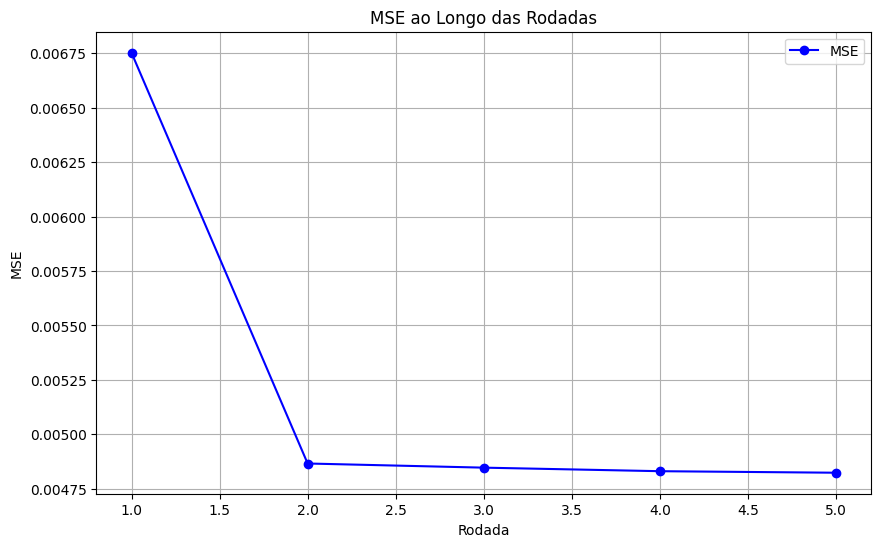

In [4]:
# Extrair os rounds e os mse
rounds = [round_num for round_num, mse in history.metrics_distributed['mse']]
mses = [mse for round_num, mse in history.metrics_distributed['mse']]

# Plotar gráfico de MSE ao longo das rodadas
plt.figure(figsize=(10, 6))
plt.plot(rounds, mses, marker='o', linestyle='-', color='b', label='MSE')
plt.title('MSE ao Longo das Rodadas')
plt.xlabel('Rodada')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()

### Gráfico de Dispersão das Previsões vs. Valores Reais para LocLat e LocLong

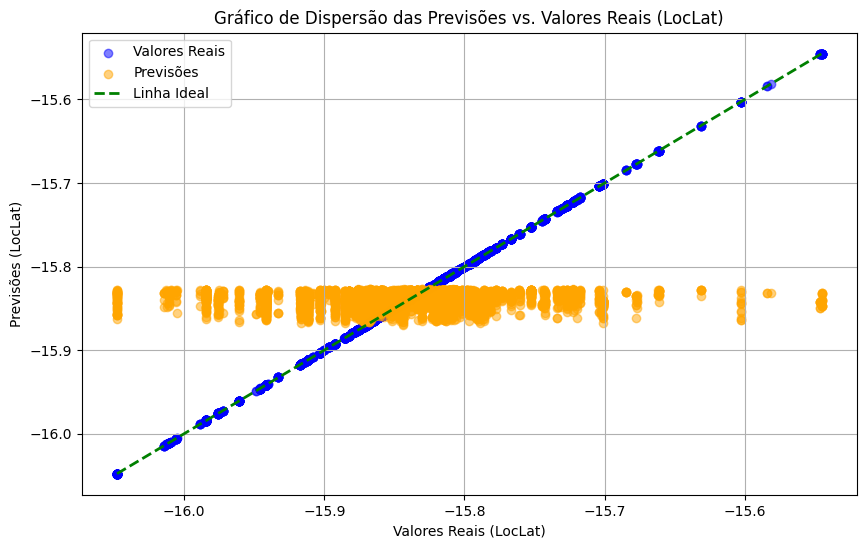

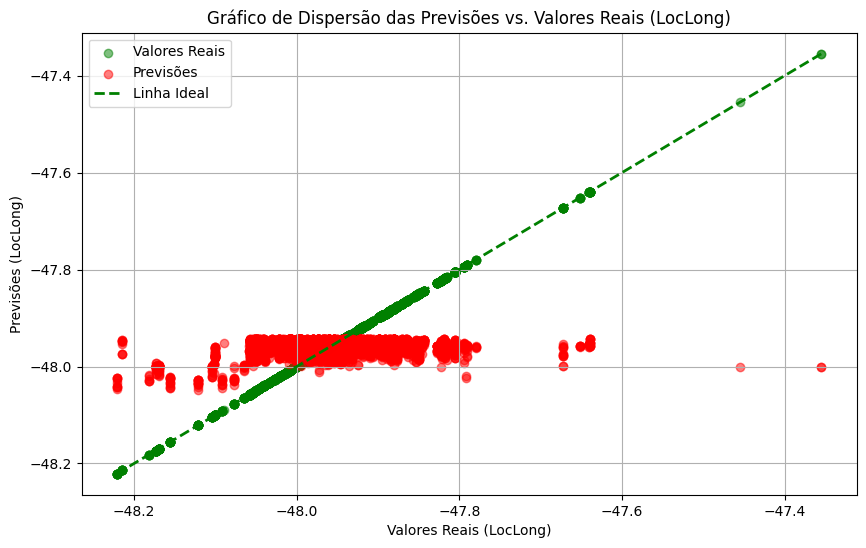

In [5]:
# Carregar previsões e rótulos salvos pelo cliente
predictions = np.loadtxt("./predictions/predictions_client.csv", delimiter=",")
labels = np.loadtxt("./predictions/labels_client.csv", delimiter=",")

# Gráfico de Dispersão das Previsões vs. Valores Reais para LocLat
plt.figure(figsize=(10, 6))
plt.scatter(labels[:, 0], labels[:, 0], color='blue', alpha=0.5, label='Valores Reais')  # Valores Reais
plt.scatter(labels[:, 0], predictions[:, 0], color='orange', alpha=0.5, label='Previsões')  # Previsões
plt.plot([labels[:, 0].min(), labels[:, 0].max()], [labels[:, 0].min(), labels[:, 0].max()], 'g--', lw=2, label='Linha Ideal')
plt.title('Gráfico de Dispersão das Previsões vs. Valores Reais (LocLat)')
plt.xlabel('Valores Reais (LocLat)')
plt.ylabel('Previsões (LocLat)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de Dispersão das Previsões vs. Valores Reais para LocLong
plt.figure(figsize=(10, 6))
plt.scatter(labels[:, 1], labels[:, 1], color='green', alpha=0.5, label='Valores Reais')  # Valores Reais
plt.scatter(labels[:, 1], predictions[:, 1], color='red', alpha=0.5, label='Previsões')  # Previsões
plt.plot([labels[:, 1].min(), labels[:, 1].max()], [labels[:, 1].min(), labels[:, 1].max()], 'g--', lw=2, label='Linha Ideal')
plt.title('Gráfico de Dispersão das Previsões vs. Valores Reais (LocLong)')
plt.xlabel('Valores Reais (LocLong)')
plt.ylabel('Previsões (LocLong)')
plt.legend()
plt.grid(True)
plt.show()

### Histograma dos erros

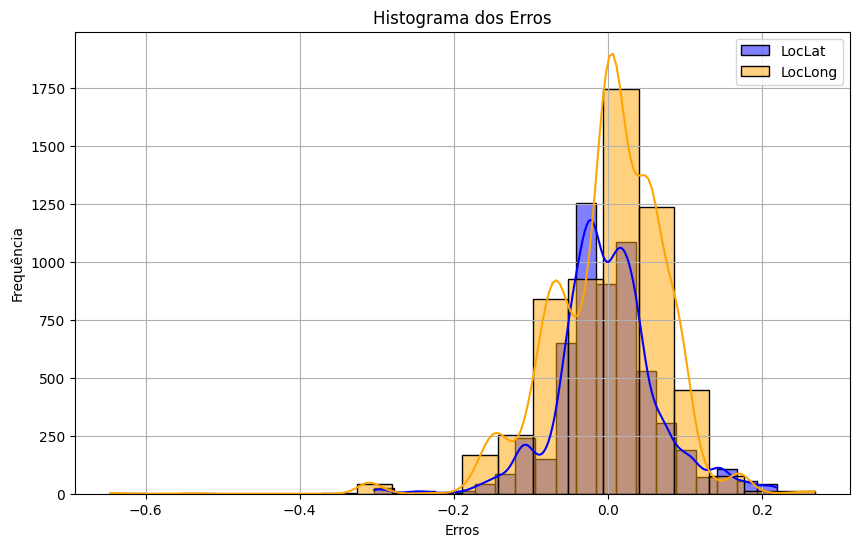

In [7]:
# Garantir que as previsões e os rótulos estejam adequadamente em duas dimensões
if predictions.ndim == 1:
    predictions = predictions.reshape(-1, 2)
if labels.ndim == 1:
    labels = labels.reshape(-1, 2)

# Plotar histograma dos erros
errors_loclat = predictions[:, 0] - labels[:, 0]  # Erros para LocLat
errors_loclong = predictions[:, 1] - labels[:, 1]  # Erros para LocLong

plt.figure(figsize=(10, 6))
sns.histplot(errors_loclat, color='blue', kde=True, label='LocLat', bins=20, alpha=0.5)
sns.histplot(errors_loclong, color='orange', kde=True, label='LocLong', bins=20, alpha=0.5)
plt.title('Histograma dos Erros')
plt.xlabel('Erros')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)
plt.show()

### Observado vs. Predição ao Longo do Tempo para LocLat e LocLong

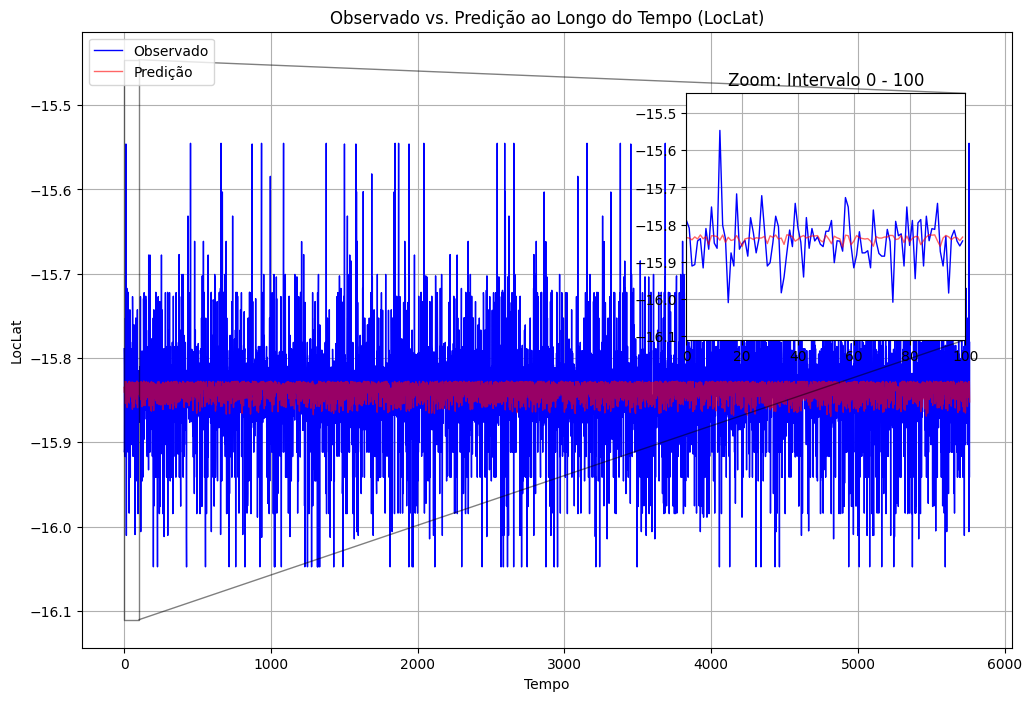

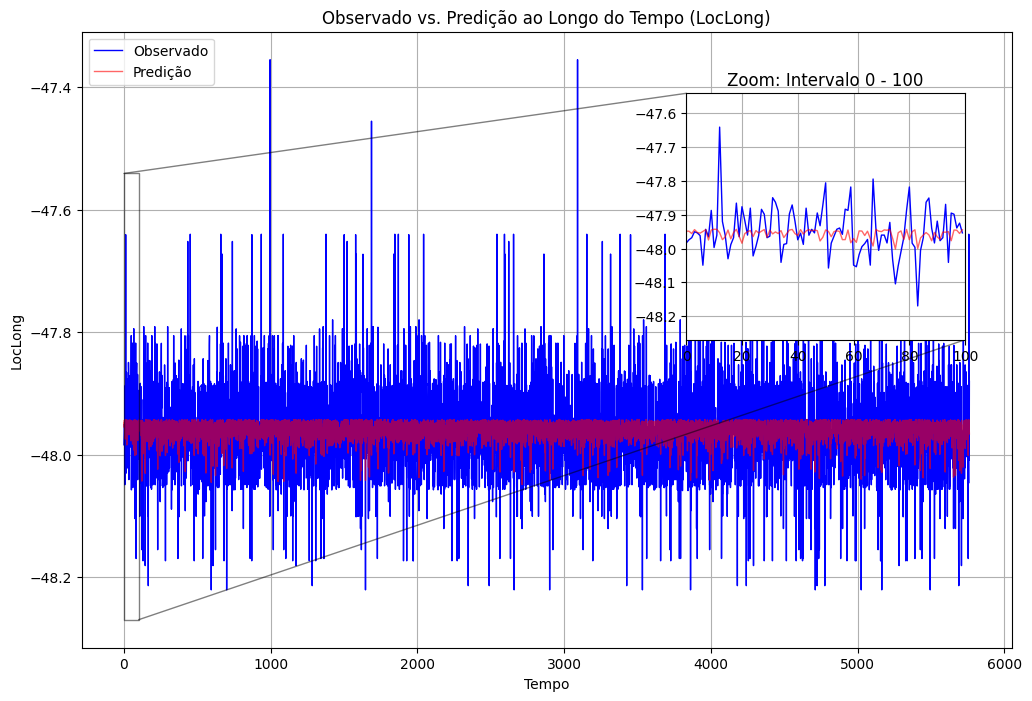

In [14]:
# Carregar previsões e rótulos salvos pelo cliente
predictions = np.loadtxt("./predictions/predictions_client.csv", delimiter=",")
labels = np.loadtxt("./predictions/labels_client.csv", delimiter=",")

# Garantir que as previsões e os rótulos estejam adequadamente em duas dimensões
if predictions.ndim == 1:
    predictions = predictions.reshape(-1, 2)
if labels.ndim == 1:
    labels = labels.reshape(-1, 2)

# Gráfico Observado vs. Predição ao Longo do Tempo para LocLat
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(labels[:, 0], color='blue', linewidth=1, label='Observado')
ax.plot(predictions[:, 0], color='red', linewidth=1, alpha=0.6, label='Predição')
ax.set_title('Observado vs. Predição ao Longo do Tempo (LocLat)')
ax.set_xlabel('Tempo')
ax.set_ylabel('LocLat')
ax.legend(loc='upper left')
ax.grid(True)

# Criar zoom no canto superior direito (intervalo 0 - 100)
axins = ax.inset_axes([0.65, 0.5, 0.3, 0.4])  # [x, y, largura, altura]
axins.plot(labels[:100, 0], color='blue', linewidth=1)
axins.plot(predictions[:100, 0], color='red', linewidth=1, alpha=0.6)
axins.set_xlim(0, 100)
axins.set_ylim(labels[:100, 0].min() - 0.1, labels[:100, 0].max() + 0.1)
axins.set_title('Zoom: Intervalo 0 - 100')
axins.grid(True)

# Conectar o zoom com a área correspondente no gráfico principal
ax.indicate_inset_zoom(axins, edgecolor='black')

plt.show()

# Gráfico Observado vs. Predição ao Longo do Tempo para LocLong
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(labels[:, 1], color='blue', linewidth=1, label='Observado')
ax.plot(predictions[:, 1], color='red', linewidth=1, alpha=0.6, label='Predição')
ax.set_title('Observado vs. Predição ao Longo do Tempo (LocLong)')
ax.set_xlabel('Tempo')
ax.set_ylabel('LocLong')
ax.legend(loc='upper left')
ax.grid(True)

# Criar zoom no canto superior direito (intervalo 0 - 100)
axins = ax.inset_axes([0.65, 0.5, 0.3, 0.4])  # [x, y, largura, altura]
axins.plot(labels[:100, 1], color='blue', linewidth=1)
axins.plot(predictions[:100, 1], color='red', linewidth=1, alpha=0.6)
axins.set_xlim(0, 100)
axins.set_ylim(labels[:100, 1].min() - 0.1, labels[:100, 1].max() + 0.1)
axins.set_title('Zoom: Intervalo 0 - 100')
axins.grid(True)

# Conectar o zoom com a área correspondente no gráfico principal
ax.indicate_inset_zoom(axins, edgecolor='black')

plt.show()